#### Analyzed by Gowri

# Global libraries

In [3]:
!pip install scikit-learn
!pip install cryptography psycopg2

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.stats import zscore
import psycopg2
from cryptography.fernet import Fernet
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

Member = pd.read_csv('common/subject-info.csv')
Athlete = Member.copy()
Activity = pd.read_csv('common/test_measure.csv')
Test = Activity.copy()

# Q1. For each participant, calculate the decline in VO2 during the final 25% of test time. Identify the top 5 athletes with the steepest drop (Fatigue Index).

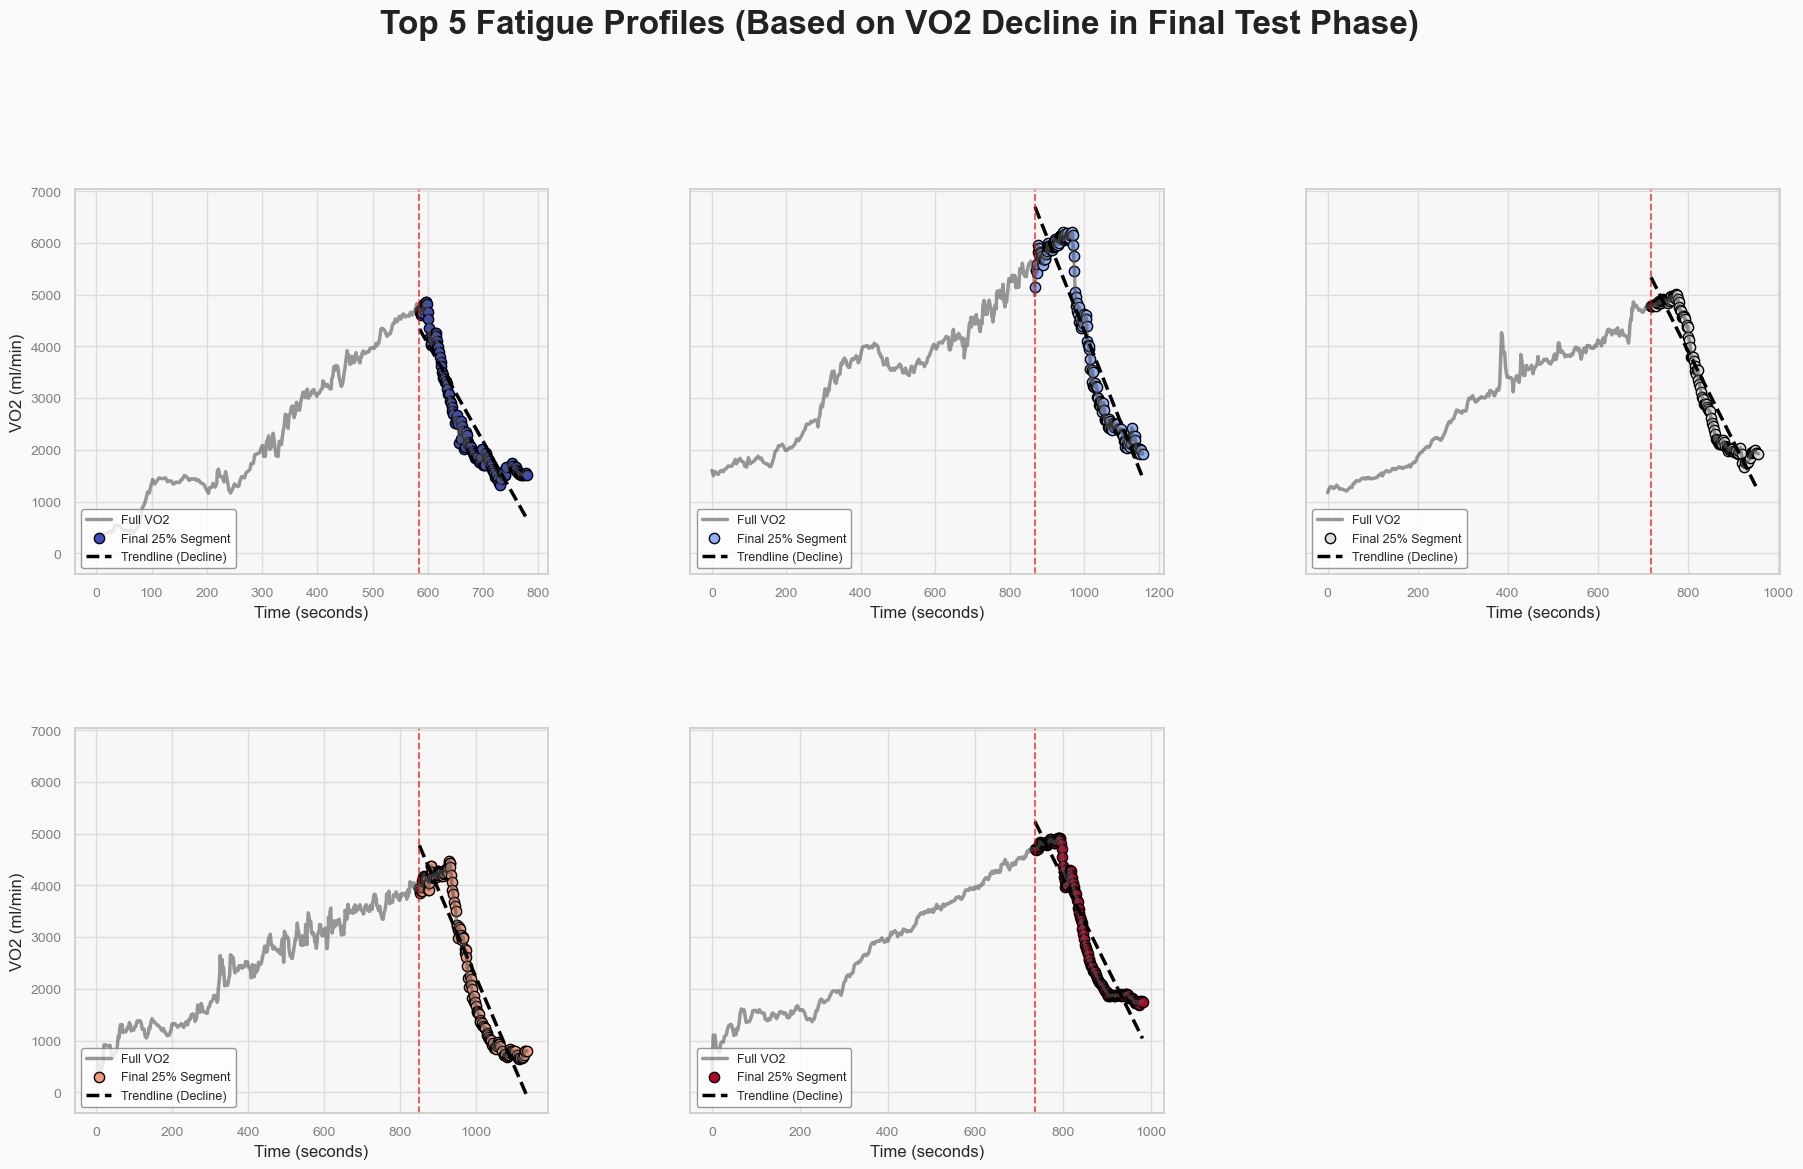

In [6]:
# ------------------------------
# Calculate Fatigue Index (VO2 decline slope)
# ------------------------------

fatigue_data = []  # Store results here

for test_id in Test['ID_test'].unique():
    test_df = Test[Test['ID_test'] == test_id].sort_values('time')

    if len(test_df) < 5:
        continue  # Too few points, skip

    # Define final 25% of test
    time_cutoff = test_df['time'].max() * 0.75
    final_phase = test_df[test_df['time'] >= time_cutoff]

    # Skip if final segment is too short
    if len(final_phase) < 3 or final_phase['VO2'].isnull().any():
        continue

    # Prepare for regression
    X = final_phase['time'].values.reshape(-1, 1)
    y = final_phase['VO2'].values.reshape(-1, 1)

    try:
        model = LinearRegression()
        model.fit(X, y)
        slope = model.coef_[0][0]  # VO2 decline rate
        fatigue_data.append({'ID_test': test_id, 'VO2_decline_slope': slope})
    except Exception as e:
        print(f"Error fitting test {test_id}: {e}")
        continue

# Turn results into a DataFrame
fatigue_df = pd.DataFrame(fatigue_data)

# ------------------------------
# Plot Top 5 Fatigue Cases
# ------------------------------

# Grab a nice gradient — not too strong, not too flat
cmap = plt.colormaps.get_cmap('coolwarm')
color_palette = [cmap(i / 4) for i in range(5)]  # 5 shades for top 5 athletes

# Use seaborn theme, but tweak a bit to feel light
sns.set_theme(style="whitegrid", font_scale=1.1, rc={
    "axes.facecolor": "#f7f7f7",
    "figure.facecolor": "#fafafa",
    "grid.color": "#dddddd"
})

# Pick the top 5 athletes with the steepest decline in VO2
top_fatigue_cases = fatigue_df.sort_values(by='VO2_decline_slope').head(5)

# Set up a 2x3 subplot grid — we’ll only use 5, so hide the last
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(22, 12), sharey=True)
axes = axes.flatten()

# Main title — slightly informal but clear
fig.suptitle(
    "Top 5 Fatigue Profiles (Based on VO2 Decline in Final Test Phase)",
    fontsize=24, fontweight='bold', color='#222', y=1.03
)

# Plot each athlete's test
for i, athlete in enumerate(top_fatigue_cases.itertuples()):
    test_data = Test[Test['ID_test'] == athlete.ID_test].sort_values(by='time')

    # Define the final 25% window
    t_cutoff = test_data['time'].max() * 0.75
    final_segment = test_data[test_data['time'] >= t_cutoff]

    ax = axes[i]
    base_color = color_palette[i]

    # Plot the full VO2 series (gray tone)
    sns.lineplot(data=test_data, x='time', y='VO2', ax=ax,
                 color='#555', linewidth=2.5, alpha=0.6, label='Full VO2')

    # Highlight final 25% points
    ax.scatter(final_segment['time'], final_segment['VO2'],
               color=base_color, s=55, edgecolor='black', linewidth=1,
               label='Final 25% Segment')

    # Fit a simple trendline over the final 25% segment
    model = LinearRegression()
    X_final = final_segment['time'].values.reshape(-1, 1)
    y_final = final_segment['VO2'].values.reshape(-1, 1)
    model.fit(X_final, y_final)
    predicted_vo2 = model.predict(X_final)

    ax.plot(final_segment['time'], predicted_vo2,
            color='black', linestyle='--', linewidth=2.5,
            label='Trendline (Decline)')
    
    # Drop a vertical marker to show where the fatigue phase starts
    # (final 25% of the test)
    ax.axvline(
        t_cutoff, 
        color='red',         # red
        linestyle='--', 
        linewidth=1.3, 
        alpha=0.7
    )
    
    # Labeling the X-axis clearly, in case someone forgets this is time series
    ax.set_xlabel("Time (seconds)", fontsize=12)

    # Label the Y-axis — always good to remind what VO2 stands for
    ax.set_ylabel("VO2 (ml/min)", fontsize=12)

    
    ax.set_xlabel("Time (seconds)", fontsize=12)
    ax.set_ylabel("VO2 (ml/min)", fontsize=12)

    # Ticks: slightly toned down
    ax.tick_params(axis='both', labelsize=10, colors='gray')

    # Legend — not too fancy, just readable
    ax.legend(loc='lower left', fontsize=9, frameon=True, facecolor='white', edgecolor='gray')

# Hide the unused last subplot
if len(top_fatigue_cases) < 6:
    for j in range(len(top_fatigue_cases), 6):
        fig.delaxes(axes[j])

# Simple spacing adjustment

plt.subplots_adjust(
    top=0.88,  
    hspace=0.4, 
    wspace=0.3  
)

plt.show()


# Q2. Plot the trend of VE/VO2 ratio (ventilatory equivalent for oxygen) over time for selected athletes.

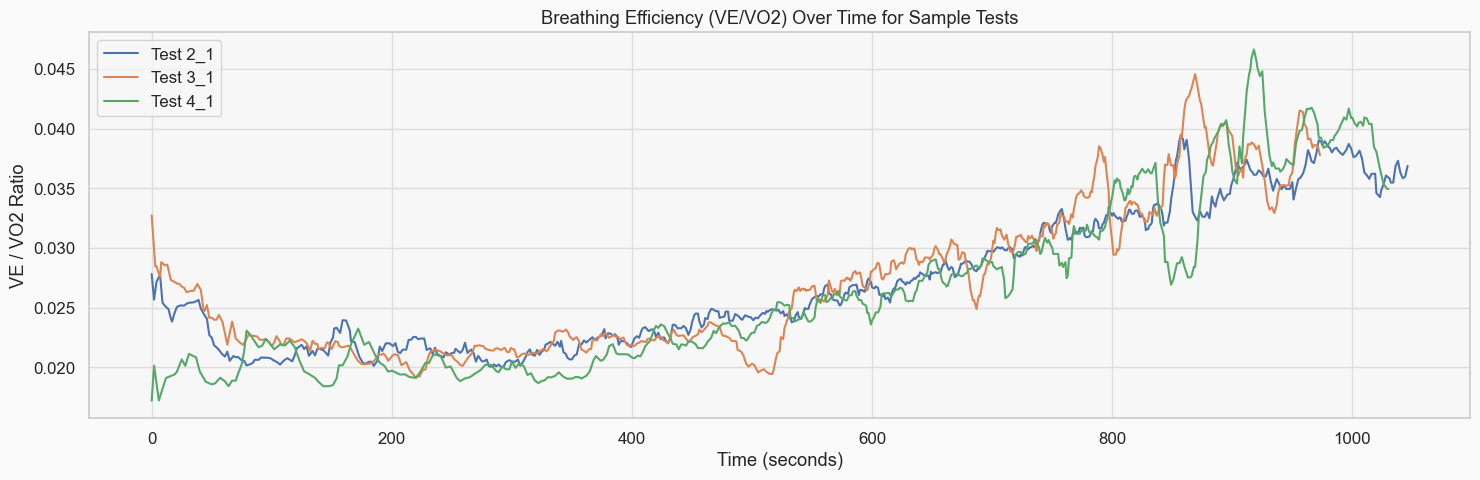

In [8]:
# Filter relevant columns and drop rows with missing values
efficiency_df = Test[['ID_test', 'time', 'VE', 'VO2']].dropna()
efficiency_df = efficiency_df[efficiency_df['VO2'] != 0]  # avoid division by zero

# Calculate VE/VO2 ratio
efficiency_df['VE_per_VO2'] = efficiency_df['VE'] / efficiency_df['VO2']

# Select 3 representative tests for plotting
example_tests = efficiency_df['ID_test'].unique()[:3]

# Plot breathing efficiency over time
plt.figure(figsize = (15, 5))
for test_id in example_tests:
    df_sub = efficiency_df[efficiency_df['ID_test'] == test_id]
    plt.plot(df_sub['time'], df_sub['VE_per_VO2'], label=f"Test {test_id}")

plt.title("Breathing Efficiency (VE/VO2) Over Time for Sample Tests")
plt.xlabel("Time (seconds)")
plt.ylabel("VE / VO2 Ratio")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Q3. Calculate and plot oxygen pulse (VO2 / HR) over time. Find participants with increasing, stable, or decreasing oxygen pulse trends.

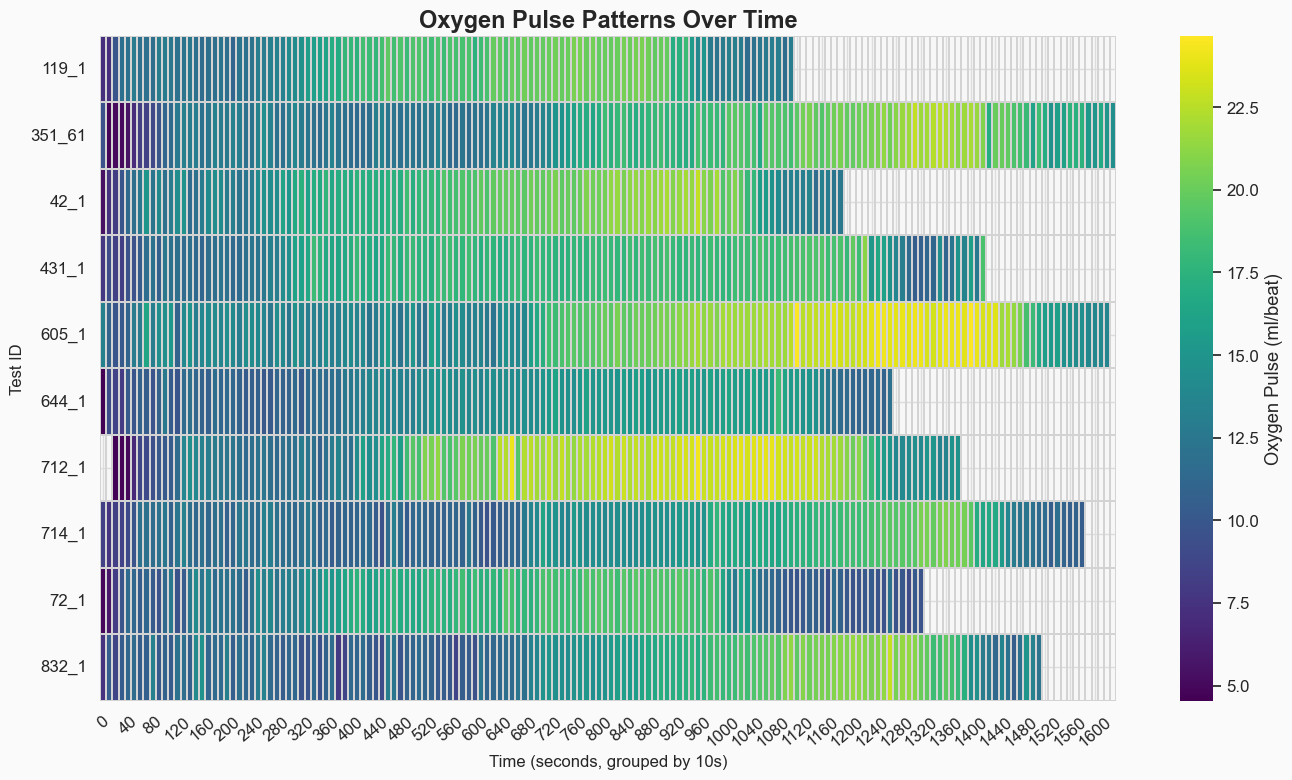

In [10]:
# Prep: Grab only what we need and clean up
pulse_df = Test[['ID_test', 'time', 'VO2', 'HR']].dropna()

# Filter out any weird HR values — don’t want divide-by-zero surprises
pulse_df = pulse_df[pulse_df['HR'] > 0]

# Calculate oxygen pulse: just VO2 divided by HR
pulse_df['Oxygen_Pulse'] = pulse_df['VO2'] / pulse_df['HR']  # in ml/beat

# Pick top 10 most active test IDs (i.e., those with the most data points)
top_ids = pulse_df['ID_test'].value_counts().head(10).index.tolist()
filtered = pulse_df[pulse_df['ID_test'].isin(top_ids)].copy()

# Bin time into 10s intervals for heatmap columns
filtered['time_bin'] = (filtered['time'] // 10 * 10).astype(int)

# Pivot the data into a format that's easy to heatmap
# Rows = test IDs, Columns = time bins, Values = avg Oxygen Pulse
heatmap_data = filtered.pivot_table(
    index='ID_test',
    columns='time_bin',
    values='Oxygen_Pulse',
    aggfunc='mean'
)

# Make sure the columns are in the right order (ascending time)
heatmap_data = heatmap_data.sort_index(axis=1)

# Plotting time!
plt.figure(figsize=(14, 8))  
sns.heatmap(
    heatmap_data,
    cmap='viridis',            
    linewidths=0.25, # Thinner gridlines for subtle separation
    linecolor='lightgray',     
    cbar_kws={'label': 'Oxygen Pulse (ml/beat)'}
)

# plot info
plt.title("Oxygen Pulse Patterns Over Time", fontsize=17, weight='bold')
plt.xlabel("Time (seconds, grouped by 10s)", fontsize=12)
plt.ylabel("Test ID", fontsize=12)
plt.xticks(rotation=40)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# Q4. Identify if a recovery phase exists in the test (speed drops to zero, HR still elevated). Flag tests where recovery was measured.

In [12]:
# Detect recovery phase: speed near zero while HR still elevated
recovery_df = Test[['ID_test', 'time', 'Speed', 'HR']].dropna()
recovery_phase_results = []

# Check for each test
for test_id, group in recovery_df.groupby('ID_test'):
    group = group.sort_values('time')
    last_30s = group[group['time'] >= (group['time'].max() - 30)]

    if len(last_30s) > 5:
        speed_near_zero = (last_30s['Speed'] < 0.5).mean() > 0.5
        avg_hr = last_30s['HR'].mean()
        if speed_near_zero and avg_hr > 80:
            recovery_phase_results.append({
                'ID_test': test_id,
                'Avg_HR_in_recovery': round(avg_hr, 1),
                'Speed_near_zero': True
            })

# Convert to DataFrame
recovery_phase_df = pd.DataFrame(recovery_phase_results)

print(recovery_phase_df)


   ID_test  Avg_HR_in_recovery  Speed_near_zero
0    138_1               106.3             True
1    201_1               115.0             True
2    235_1               132.7             True
3    244_1               103.9             True
4    245_1               107.4             True
5    261_1               111.1             True
6    286_1               100.6             True
7    307_1               135.8             True
8    322_1                84.5             True
9     38_1               121.5             True
10    39_1               100.2             True
11   479_1                99.9             True
12  506_21               107.8             True
13    51_1               112.9             True
14   545_1                97.5             True
15   557_1               118.4             True
16   558_1               113.9             True
17   572_1               122.2             True
18   593_1                91.6             True
19   824_1               140.0          

# Q5. Which athletes demonstrate abnormal breathing patterns (RR or VE) relative to VO2?

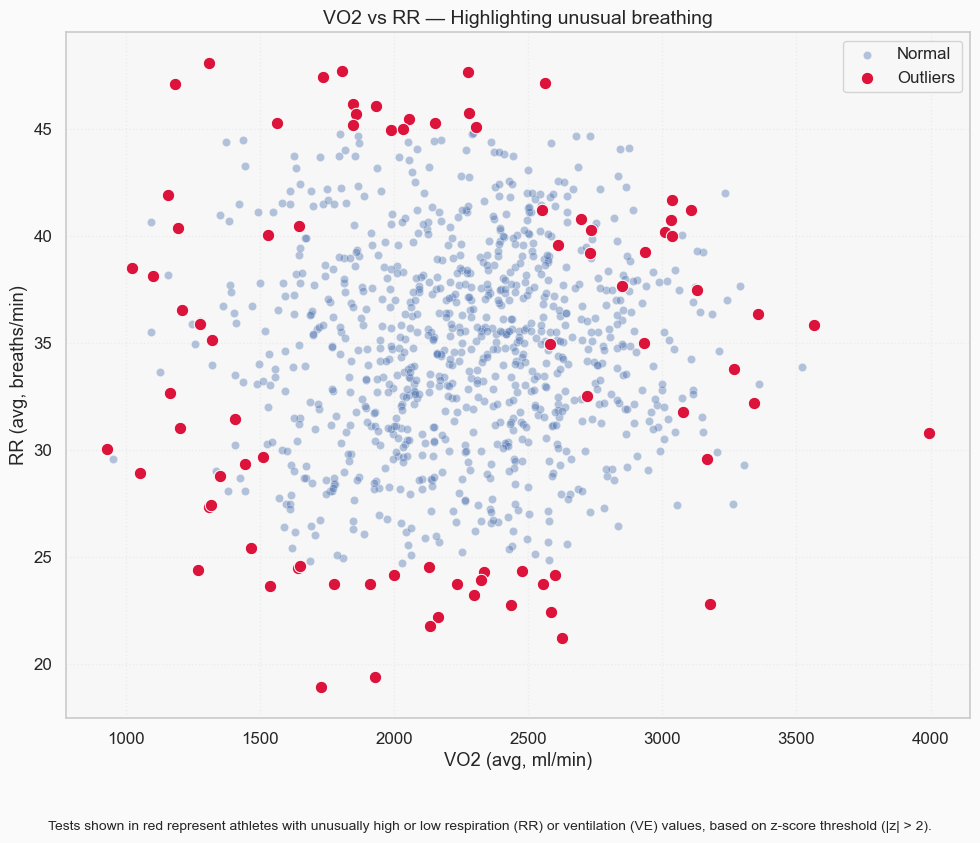

In [14]:
# --- Data Prep  ---
breath_df = Test[['ID_test', 'VO2', 'RR', 'VE']].dropna()
breath_df = breath_df[breath_df['VO2'] > 0]

summary_df = breath_df.groupby('ID_test').agg({
    'VO2': 'mean',
    'RR': 'mean',
    'VE': 'mean'
}).reset_index()

summary_df['RR_zscore'] = zscore(summary_df['RR'])
summary_df['VE_zscore'] = zscore(summary_df['VE'])

# Identify outliers
outliers = summary_df[
    (summary_df['RR_zscore'].abs() > 2) |
    (summary_df['VE_zscore'].abs() > 2)
].copy()

# --- Plot Only ---
plt.figure(figsize=(10, 8))
sns.scatterplot(data=summary_df, x='VO2', y='RR', label='Normal', alpha=0.4)
sns.scatterplot(data=outliers, x='VO2', y='RR', color='crimson', s=80, label='Outliers')

# Title and labels
plt.title("VO2 vs RR — Highlighting unusual breathing", fontsize=14)
plt.xlabel("VO2 (avg, ml/min)")
plt.ylabel("RR (avg, breaths/min)")
plt.grid(True, linestyle=':', alpha=0.4)  # subtle dotted grid
plt.legend()

# Caption
plt.figtext(
    0.5, -0.05,
    "Tests shown in red represent athletes with unusually high or low respiration (RR) or ventilation (VE) values, based on z-score threshold (|z| > 2).",
    wrap=True, horizontalalignment='center', fontsize=10
)

plt.tight_layout()
plt.show()


# Q6. How do we store encrypted subject data and decrypt it only when needed — using Python or PostgreSQL?

In [16]:
import os
import psycopg2
from cryptography.fernet import Fernet

# === Load or create your encryption key ===
key_path = "secret.key"

# Only generate if the file doesn't exist
if not os.path.exists(key_path):
    key = Fernet.generate_key()
    with open(key_path, "wb") as f:
        f.write(key)
    print("New encryption key generated and saved.")
else:
    with open(key_path, "rb") as f:
        key = f.read()
    print("Encryption key loaded.")

cipher = Fernet(key)

# === Encrypt a test name ===
original_name = "Michale John"
encrypted_name = cipher.encrypt(original_name.encode()).decode()

# === Connect to PostgreSQL and reset table ===
try:
    conn = psycopg2.connect(
        dbname="treadmill",
        user="postgres",
        password="postgres",
        host="localhost",
        port="5433"  # Update if needed
    )
    cur = conn.cursor()

    # Drop and recreate table to remove bad data (only for testing)
    cur.execute("DROP TABLE IF EXISTS athletes;")
    cur.execute("""
        CREATE TABLE athletes (
            id SERIAL PRIMARY KEY,
            name_encrypted TEXT
        );
    """)
    conn.commit()

    # Insert fresh, valid encrypted data
    cur.execute("INSERT INTO athletes (name_encrypted) VALUES (%s)", (encrypted_name,))
    conn.commit()
    print("Encrypted name inserted successfully.")

except Exception as e:
    print("Error during DB setup or insert:", e)

finally:
    cur.close()
    conn.close()


Encryption key loaded.
Encrypted name inserted successfully.


### Decryption Cell (Display decrypted names)

In [18]:
import psycopg2
from cryptography.fernet import Fernet

# Load the encryption key again
with open("secret.key", "rb") as f:
    key = f.read()

cipher = Fernet(key)

# Connect and read + decrypt
try:
    conn = psycopg2.connect(
        dbname="treadmill",
        user="postgres",
        password="postgres",
        host="localhost",
        port="5433"
    )
    cur = conn.cursor()

    cur.execute("SELECT id, name_encrypted FROM athletes")
    rows = cur.fetchall()

    print("Decrypted Names:\n")
    for row in rows:
        athlete_id, encrypted_val = row
        if encrypted_val:
            decrypted = cipher.decrypt(encrypted_val.encode()).decode()
            print(f"ID {athlete_id}: {decrypted}")
        else:
            print(f"ID {athlete_id}: (no name stored)")

except Exception as e:
    print("Error during decryption:", e)

finally:
    cur.close()
    conn.close()


Decrypted Names:

ID 1: Michale John


# Q7. Which participants (by age group) have taken the most treadmill tests?

In [20]:
import pandas as pd

# Load subject info and treadmill test data
subjects = pd.read_csv("common/subject-info.csv")
tests = pd.read_csv("common/test_measure.csv")

# Just making sure IDs match format (sometimes they're int vs str)
subjects['ID'] = subjects['ID'].astype(str)
tests['ID'] = tests['ID'].astype(str)

# Merge to bring age into test records
merged = tests.merge(subjects[['ID', 'Age']], on='ID', how='left')

# Group ages into more readable buckets
merged['age_group'] = pd.cut(
    merged['Age'],
    bins=[0,29,39,49,59,69,100],
    labels=['<30','30s','40s','50s','60s','70+']
)

# Count how many tests per age group (not how many people)
unique_tests = merged[['ID_test', 'age_group']].drop_duplicates()
grouped = unique_tests.groupby('age_group', observed=True).size().reset_index(name='Test Count')

# Display result in a clean way
print("Treadmill Tests by Age Group with test count:\n")
print(grouped)

Treadmill Tests by Age Group with test count:

  age_group  Test Count
0       <30         564
1       30s         267
2       40s         143
3       50s          42
4       60s           6


# Q8. What is the average test duration across different age groups?

In [22]:
# We'll just take the max time and subtract the min time for each session.
test_times = (
    tests.groupby('ID_test')['time']
    .agg(lambda t: t.max() - t.min())
    .reset_index()
)

# This was originally called 'time' in the agg result, so let's rename it to something more descriptive
test_times.rename(columns={'time': 'Duration'}, inplace=True)

# Getting participant info — grabbing their ID and age
# There can be multiple rows per test, so let's clean that up
test_subjects = tests[['ID_test', 'ID']].drop_duplicates()
test_times = test_times.merge(test_subjects, on='ID_test', how='left')

# Bringing in age info from the master 'subjects' table
test_times = test_times.merge(subjects[['ID', 'Age']], on='ID', how='left')

# Let's break people down into age brackets — might be easier to spot patterns that way
ageBrackets = [0,29,39,49,59,69,100]
ageLabels = ['<30','30s','40s','50s','60s','70+']  # TODO: refine these later if needed
test_times['age_group'] = pd.cut(test_times['Age'], bins=ageBrackets, labels=ageLabels)

# Now let's calculate the average test duration within each age group
# Should be straightforward, just grouping and averaging
avg_durations = (
    test_times
    .groupby('age_group', observed=True)['Duration']
    .mean()
    .reset_index()
)

# Rename column just to make the printout prettier
avg_durations.rename(columns={'Duration': 'Average Duration (s)'}, inplace=True)

# Show it
print("Average test duration by age group:\n")
print(avg_durations.to_string(index=False))


Average test duration by age group:

age_group  Average Duration (s)
      <30           1092.738255
      30s           1122.099379
      40s           1108.755319
      50s           1140.181818
      60s           1127.666667


# Q9. How does test duration differ between males and females?

In [24]:
# Calculate test duration per session
test_durations = (
    tests.groupby('ID_test')['time']
    .agg(lambda t: t.max() - t.min())
    .reset_index()
    .rename(columns={'time': 'Duration'})
)

# Add participant ID from the test records
id_map = tests[['ID_test', 'ID']].drop_duplicates()
test_durations = test_durations.merge(id_map, on='ID_test', how='left')

# Add gender info from subjects table
test_durations = test_durations.merge( subjects[['ID','Sex']], on='ID', how='left' )

# Map 0/1 to actual gender labels for readability
gender_mapping = {0:'Male',1:'Female'}
test_durations['Gender'] = test_durations['Sex'].map(gender_mapping)

# Group by Gender and calculate average duration
avg_duration_by_gender = (
    test_durations.groupby('Gender')['Duration']
    .mean()
    .reset_index()
)

# Display result
print("Average test duration by gender:")
print(avg_duration_by_gender.to_string(index=False))


Average test duration by gender:
Gender    Duration
Female  943.139896
  Male 1131.966816


# Q10. Who had the longest single treadmill test overall?

In [26]:
# Calculate test duration for each test session
test_durations = (
    tests.groupby('ID_test')['time']
    .agg(lambda t: t.max() - t.min())
    .reset_index()
    .rename(columns={'time': 'Duration'})
)

# Get participant IDs linked to test sessions
id_map = tests[['ID_test', 'ID']].drop_duplicates()
test_durations = test_durations.merge(id_map, on='ID_test', how='left')

# Merge with subject info
test_durations = test_durations.merge(subjects[['ID','Age','Sex']], on='ID', how='left')

# Convert Sex to Gender
test_durations[ 'Gender' ] = test_durations[ 'Sex' ].map({0:'Male',1:'Female'})

# Find the test with the longest duration
longest_test = test_durations.loc[test_durations['Duration'].idxmax()]

# Display the result
print("Longest Single Treadmill Test \n")
print(f"Participant ID : {longest_test['ID']}")
print(f"Test ID        : {longest_test['ID_test']}")
print(f"Duration       : {longest_test['Duration']} seconds")
print(f"Age            : {longest_test['Age']}")
print(f"Gender         : {longest_test['Gender']}")


Longest Single Treadmill Test 

Participant ID : 699
Test ID        : 699_1
Duration       : 1712 seconds
Age            : 39.7
Gender         : Male


# Q11. What is the distribution of BMI among all participants?

Distribution of Participants by BMI Group:

BMI_Group
Underweight     28
Normal         670
Overweight     269
Obese           25


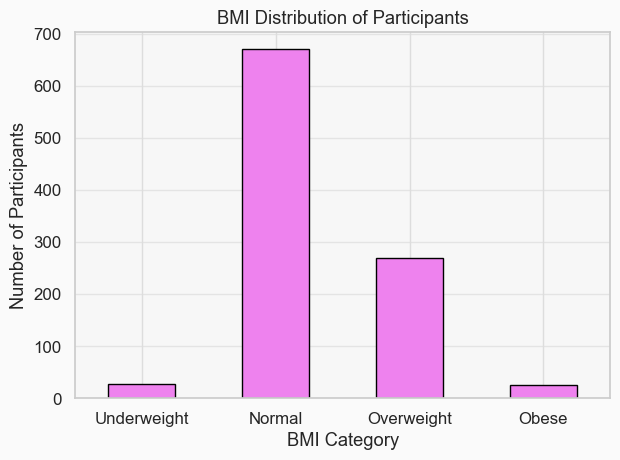

In [28]:

# Load the subject data
subjects = pd.read_csv("common/subject-info.csv")

# Quick conversion: height in cm → meters
subjects['height_m'] = subjects['Height'] / 100  # keep units clean

# BMI
subjects['BMI'] = subjects['Weight'] / (subjects['height_m'] ** 2)

# WHO categories — we'll keep it simple and use 4 standard buckets
bmi_Bins_value = [0,18.5,25,30,float('inf')]
bmi_Labels_value = ['Underweight','Normal','Overweight','Obese']

# Group people by BMI category
subjects['BMI_Group'] = pd.cut(
    subjects['BMI'],
    bins=bmi_Bins_value,
    labels=bmi_Labels_value,
    right=False  # include lower bound, exclude upper
)

# Count how many people fall into each group
bmi_counts = subjects['BMI_Group'].value_counts().sort_index()

# Print results in a tidy, readable format
print("Distribution of Participants by BMI Group:\n")
print(bmi_counts.to_string())

bmi_counts.plot(kind='bar', color='violet', edgecolor='black')
plt.title("BMI Distribution of Participants")
plt.ylabel("Number of Participants")
plt.xlabel("BMI Category")
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.7)
plt.tight_layout()
plt.show()

# Q12.What is the distribution of treadmill test durations across all participants?

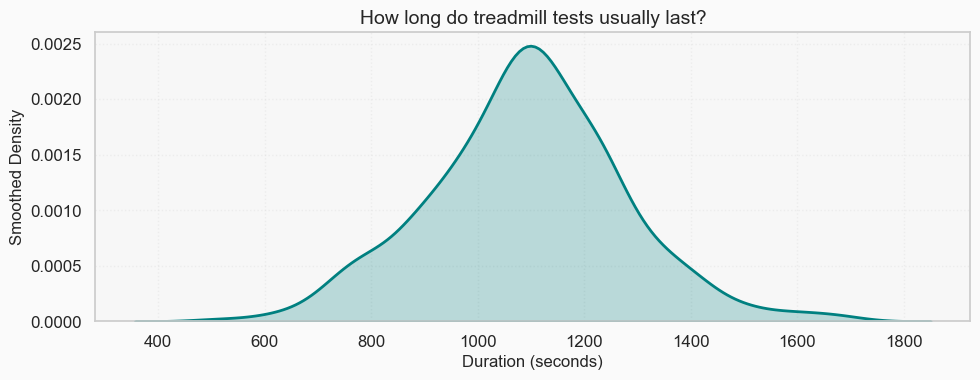

In [30]:
# Calculate duration for each test (last time - first time per ID)
durations = (
    tests.groupby('ID_test')['time']
    .agg(lambda t: t.max() - t.min())
    .reset_index()
    .rename(columns={'time': 'Duration'})
)

# Plotting the distribution using KDE

plt.figure(figsize=(10, 4))

# Be sure to pass a *Series*, not DataFrame, to kdeplot
sns.kdeplot(data=durations['Duration'], fill=True, color='teal', linewidth=2)

# Friendly and informal but informative title
plt.title("How long do treadmill tests usually last?", fontsize=14)

# Clear axis labels
plt.xlabel("Duration (seconds)", fontsize=12)
plt.ylabel("Smoothed Density", fontsize=12)

# Light dotted grid for better readability
plt.grid(True, linestyle=':', alpha=0.4)

plt.tight_layout()
plt.show()

# Q13. What does the distribution of respiration rate values look like across all tests? Are there any outliers?

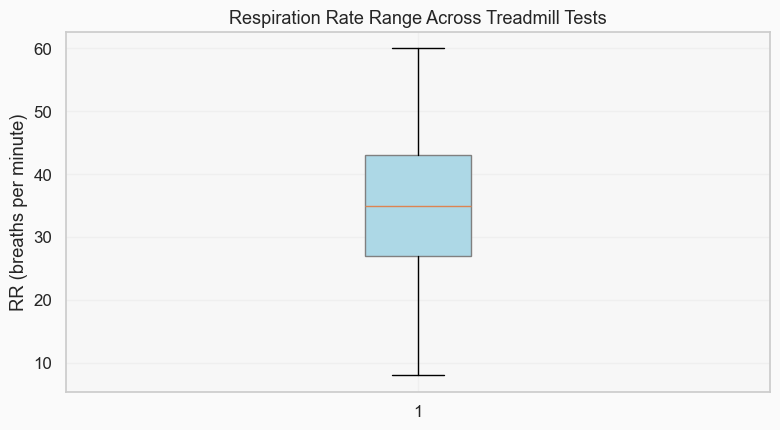

Total RR values analyzed: 555303
Potential outliers detected (z > 3): 0
No major statistical outliers detected based on z-score > 3.


In [32]:
# Load the data
tests = pd.read_csv("common/test_measure.csv")

# Get non-null respiration rate values
rr_values = tests['RR'].dropna()

# Optional: check for statistical outliers using z-scores
z_scores = zscore(rr_values)
outliers = rr_values[np.abs(z_scores) > 3]

# Plot the boxplot
plt.figure(figsize=(8, 4.5))
plt.boxplot(rr_values, vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightblue', edgecolor='gray'))

plt.title("Respiration Rate Range Across Treadmill Tests", fontsize=13)
plt.ylabel("RR (breaths per minute)")
plt.grid(visible=True, alpha=0.3)
plt.tight_layout()
plt.show()

# Summary
print(f"Total RR values analyzed: {len(rr_values)}")
print(f"Potential outliers detected (z > 3): {len(outliers)}")
if not outliers.empty:
    print("Outlier values:")
    print(outliers.sort_values().to_string(index=False))
else:
    print("No major statistical outliers detected based on z-score > 3.")


# Q14.What is the average test duration across different BMI groups?

In [34]:
# Make sure IDs are treated consistently across files
Athlete['ID'] = Athlete['ID'].astype(str)
Test['ID'] = Test['ID'].astype(str)

# Rough BMI prep: convert height to meters first
Athlete['height_m'] = Athlete['Height'] / 100  # height was in cm

# BMI formula — weight (kg) divided by height in meters squared
Athlete['BMI'] = Athlete['Weight'] / (Athlete['height_m'] ** 2)

# Set up BMI groups based on WHO
bmiValues= [0,18.5,25,30, float('inf')]
LabelValues = ['Underweight', 'Normal', 'Overweight', 'Obese']

# Tag each person with their BMI group
Athlete['BMI_Group'] = pd.cut(
    Athlete['BMI'],
    bins=bmiValues,
    labels=LabelValues,
    right=False  # include lower bound in the bin
)
# Add BMI group info into test data
merged = Test.merge(Athlete[['ID', 'BMI_Group']], on='ID', how='left')

# Group by BMI category and get average treadmill duration
avg_time_by_bmi = merged.groupby('BMI_Group', observed=True)['time'].mean().reset_index()

# Display results
print("\n Average Treadmill Test Duration by BMI Group:\n")
print(avg_time_by_bmi.to_string(index=False))



 Average Treadmill Test Duration by BMI Group:

  BMI_Group       time
Underweight 564.096687
     Normal 650.013360
 Overweight 609.645236
      Obese 501.519937


# Q15. What is the most common test duration range among participants?

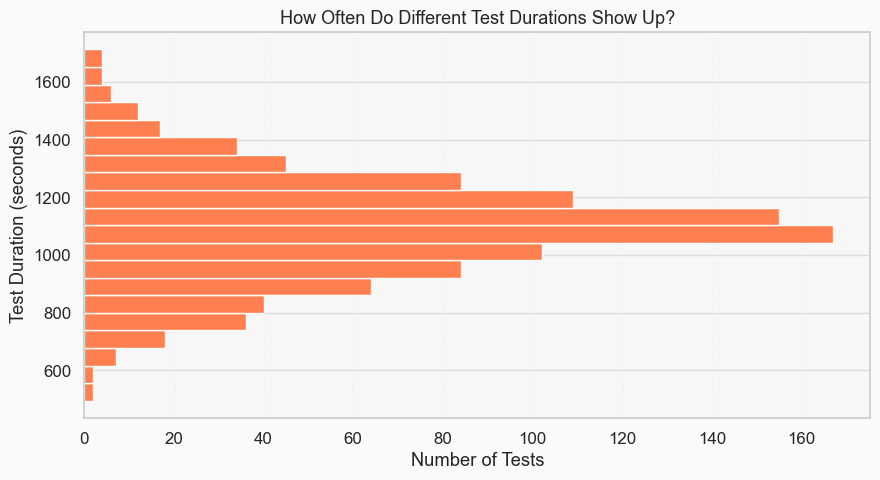

In [36]:
import matplotlib.pyplot as plt

# Calculate duration for each test session
durations = (
    tests.groupby('ID_test')['time']
    .agg(lambda t: t.max() - t.min())
)

# Drop missing just in case (though this should be clean)
durations = durations.dropna()

#  Horizontal histogram of durations
fig, ax = plt.subplots(figsize=(9, 5))
ax.hist(durations, bins=20, color='coral', edgecolor='white', orientation='horizontal')

ax.set_title("How Often Do Different Test Durations Show Up?", fontsize=13)
ax.set_xlabel("Number of Tests")
ax.set_ylabel("Test Duration (seconds)")

# clean grid look
ax.grid(visible=True, axis='x', linestyle=':', alpha=0.25)

plt.tight_layout()
plt.show()


# Q16. What does a grouped bar chart of average treadmill test duration across BMI groups and sex reveal?

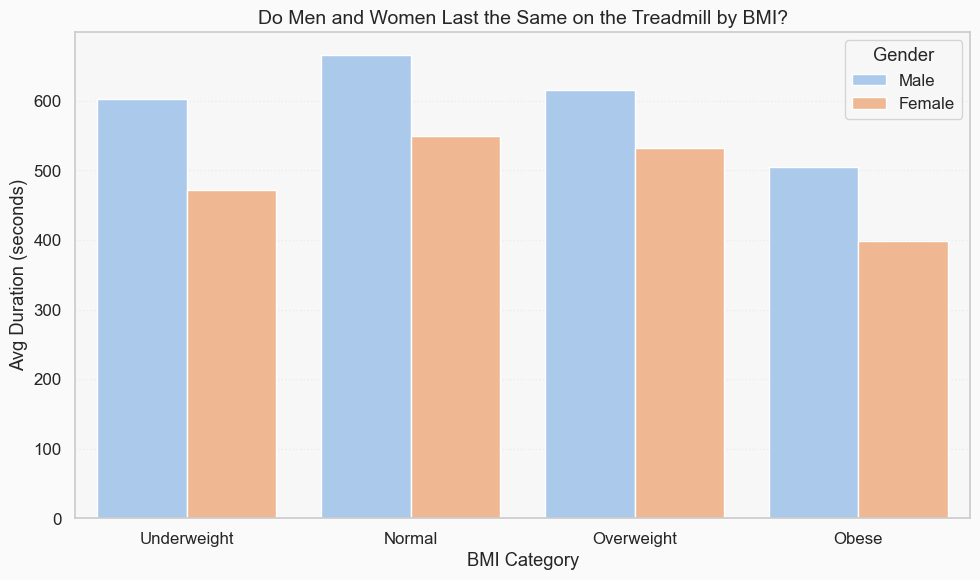

In [38]:
# Load your data (adjust paths as needed)
Athlete = pd.read_csv("common/subject-info.csv")
Test = pd.read_csv("common/test_measure.csv")

# Make sure IDs match across both files
Athlete['ID'] = Athlete['ID'].astype(str)
Test['ID'] = Test['ID'].astype(str)

# Compute BMI
Athlete['height_m'] = Athlete[ 'Height' ]/100  # convert cm to meters
Athlete['BMI'] = Athlete[ 'Weight'] / (Athlete['height_m'] ** 2)

# Assign BMI groups
bodymassindex_bins = [0,18.5,25,30,float('inf')] # assign the values
bodymassindex_labels = ['Underweight','Normal','Overweight','Obese'] #bmi labels
Athlete['BMI_Group'] = pd.cut(
    Athlete['BMI'],
    bins=bodymassindex_bins,
    labels=bodymassindex_labels,
    right=False  # include lower bound, exclude upper
)

# Merge BMI and sex info into the test data
merged = Test.merge(
    Athlete[['ID', 'Sex', 'BMI_Group']],
    on='ID',
    how='left'
)

# Calculate average test duration grouped by sex and BMI group
avg_duration = (
    merged.groupby(['Sex', 'BMI_Group'], observed=True)['time']
    .mean()
    .reset_index()
    .dropna()
)

#  Map sex values for readability
sex_map = {0: 'Male', 1: 'Female'}
avg_duration['Sex'] = avg_duration['Sex'].map(sex_map)

# Plotting grouped bar chart
plt.figure(figsize=(10, 6))
sns.barplot(
    data=avg_duration,
    x='BMI_Group',
    y='time',
    hue='Sex',
    palette='pastel'
)

plt.title("Do Men and Women Last the Same on the Treadmill by BMI?", fontsize=14)
plt.xlabel("BMI Category")
plt.ylabel("Avg Duration (seconds)")
plt.legend(title='Gender')
plt.grid(axis='y', linestyle=':', alpha=0.4)

plt.tight_layout()
plt.show()


# Q17. Can we classify participants who will last more than 800 seconds on the treadmill using respiration rate and treadmill speed?


 Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.90      0.90     94870
           1       0.78      0.80      0.79     43956

    accuracy                           0.87    138826
   macro avg       0.85      0.85      0.85    138826
weighted avg       0.87      0.87      0.87    138826



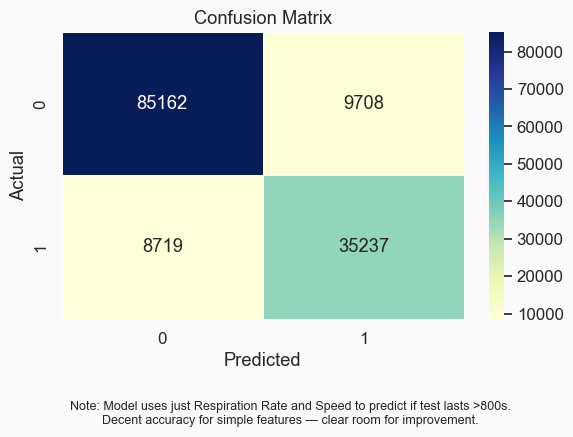

In [40]:

# Make sure IDs are strings (sometimes they're numeric)
Athlete['ID'] = Athlete['ID'].astype(str)
Test['ID'] = Test['ID'].astype(str)

# Drop rows missing key test measurements
Test = Test.dropna(subset=['time', 'RR', 'Speed'])

# We'll classify tests as 'long' if they last more than 800 seconds
Test['long_duration'] = (Test['time'] > 800).astype(int)

# Features: using just RR and treadmill speed
X = Test[['RR', 'Speed']]
y = Test['long_duration']

# Split the dataset — standard 75/25 train-test split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.25, random_state = 42)

# Fit a random forest — simple, quick, and pretty good
clf = RandomForestClassifier( random_state = 42 )
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Show how well we did
print("\n Classification Report:\n")
print(classification_report(y_test, y_pred))

# Plot confusion matrix just to visualize balance
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', linewidths=0.5)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.figtext(
    0.5, -0.08,
    "Note: Model uses just Respiration Rate and Speed to predict if test lasts >800s.\nDecent accuracy for simple features — clear room for improvement.",
    ha='center', fontsize=9, wrap=True
)
plt.show()